#### Import Modules

In [1]:
import os
import itertools
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from pathos.multiprocessing import ProcessingPool as Pool

#### Some Settings

In [2]:
property_list = ['logP', 'tPSA', 'QED']

tol = [0.4, 8, 0.03]
trg_prop_settings = {
    'logP': [ 1.0,   2.0,  3.0],
    'tPSA': [30.0,  60.0, 90.0],
    'QED' : [ 0.6, 0.725, 0.85],
}

file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/p-sampling'
file_name_list = ['pvaetf1-15', 'pvaetf2-15', 'pvaetf3-15']

#### Define Functions

In [3]:
def HAC(mol):
    return mol.GetNumHeavyAtoms()


def add_hac(df):
    mols = list(map(Chem.MolFromSmiles, df['scaffold']))
    df['HAC'] = list(map(HAC, mols))
    return df


def get_mol(smi_or_mol):
    """convert smiles to mol. (copied from molgpt)
    """
    if isinstance(smi_or_mol, str):
        if len(smi_or_mol) == 0:
            return None
        mol = Chem.MolFromSmiles(smi_or_mol)
        if mol is None:
            return None
        try:
            Chem.SanitizeMol(mol)
        except ValueError:
            return None
        return mol
    return smi_or_mol


def murcko_scaffold(smi_or_mol):
    mol = get_mol(smi_or_mol)
    if mol is None:
        return None
    return MurckoScaffoldSmiles(mol=mol)


def get_trg_prop_list():
    # get property combinations
    prop_set = (trg_prop_settings[p] for p in property_list)
    prop_comb = list(itertools.product(*prop_set))
    trg_prop_list = [list(c) for c in prop_comb]
    return trg_prop_list


def get_n_train():
    n_train = []
    trg_prop_list = get_trg_prop_list()
    train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])

    for i, prop in enumerate(trg_prop_list):
        filtered = train[(prop[0] - tol[0] <= train.logP) & (train.logP <= prop[0] + tol[0])]
        filtered = filtered[(prop[1] - tol[1] <= filtered.tPSA) & (filtered.tPSA <= prop[1] + tol[1])]
        filtered = filtered[(prop[2] - tol[2] <= filtered.QED) & (filtered.QED <= prop[2] + tol[2])]
        n_train.append(len(filtered))
    return n_train


def plot_smiles_group(smiles, save_path, substructure=None, n_per_mol=None,
                      img_size=None, descriptions=None, n_jobs=1):
    kwargs = {}
    kwargs['useSVG'] = False
    kwargs['returnPNG'] = False
    # kwargs['vspace'] = 2

    molecules = list(map(Chem.MolFromSmiles, smiles))
    kwargs['mols'] = molecules
    
    if substructure:
        substr_mols = list(map(Chem.MolFromSmiles, substructure))
        highlights = []
        for i, mol in enumerate(molecules):
            match = mol.GetSubstructMatch(substr_mols[i])
            atom_highlights = set(match)
            bond_highlights = set()
            for atom_idx in match:
                atom_bonds = mol.GetAtomWithIdx(atom_idx).GetBonds()
                for bond in atom_bonds:
                    if bond.GetBeginAtomIdx() in match and bond.GetEndAtomIdx() in match:
                        bond_highlights.add(bond.GetIdx())
            highlights.append((atom_highlights, bond_highlights))
        kwargs['highlightAtomLists'] = [hl_atoms for hl_atoms, _ in highlights]
        kwargs['highlightBondLists'] = [hl_bonds for _, hl_bonds in highlights]

    draw_options = Draw.MolDrawOptions()
    # draw_options.legendFraction = 0.2
    draw_options.legendFontSize = 24
    # draw_options.rowSpacing = 0.2
    # kwargs['subImgSize'] = draw_options
    
    if n_per_mol is not None:
        kwargs['molsPerRow'] = n_per_mol
    if img_size is not None:
        kwargs['subImgSize'] = img_size
    if descriptions is not None:
        kwargs['legends'] = descriptions
    kwargs['drawOptions'] = draw_options

    img = Draw.MolsToGridImage(**kwargs)

    img.save(save_path)


def mapper(fn, obj, n_jobs):
    if n_jobs == 1:
        res = list(map(fn, obj))
    else:
        with Pool(n_jobs) as pool:
            res = pool.map(fn, obj)
    return res

#### Get Metrics

In [4]:
# get metrics

metric1 = pd.read_csv(os.path.join(file_folder, file_name_list[0], 'metric.csv'), index_col=[0])
metric2 = pd.read_csv(os.path.join(file_folder, file_name_list[1], 'metric.csv'), index_col=[0])
metric3 = pd.read_csv(os.path.join(file_folder, file_name_list[2], 'metric.csv'), index_col=[0])
metric = (metric1 + metric2 + metric3) / 3

metric['n_train'] = get_n_train()
metric.head()

,valid,unique,novel,intDiv,logP-MSE,logP-MAE,logP-SD,tPSA-MSE,tPSA-MAE,tPSA-SD,QED-MSE,QED-MAE,QED-SD,valid_in_tolerance,unique_in_tolerance,n_train
0,0.949567,0.550689,0.986730,0.788468,0.144686,0.249011,0.278470,0.565726,3.512734,4.156336,0.063702,0.091402,0.083241,0.116600,0.087167,13
1,0.971367,0.560882,0.983900,0.801811,0.100302,0.226424,0.265570,0.664836,3.113228,3.903547,0.006414,0.032025,0.044351,0.445267,0.213233,102
2,0.952167,0.636293,0.988780,0.804408,0.121971,0.257259,0.304432,1.393466,3.391934,4.279533,-0.030395,0.037890,0.039429,0.381367,0.189767,136
3,0.934000,0.897238,0.967109,0.845826,0.066162,0.229601,0.291245,0.539355,3.416526,4.350589,0.046713,0.081571,0.093025,0.242267,0.199933,530
4,0.951200,0.924318,0.953301,0.847053,0.045114,0.213689,0.272950,0.406253,3.171443,4.162405,0.008889,0.042757,0.057959,0.398067,0.351533,2842


#### Scatter Plot of Metrics 
- Validity, Uniqueness, Novelty, Internal Diversity

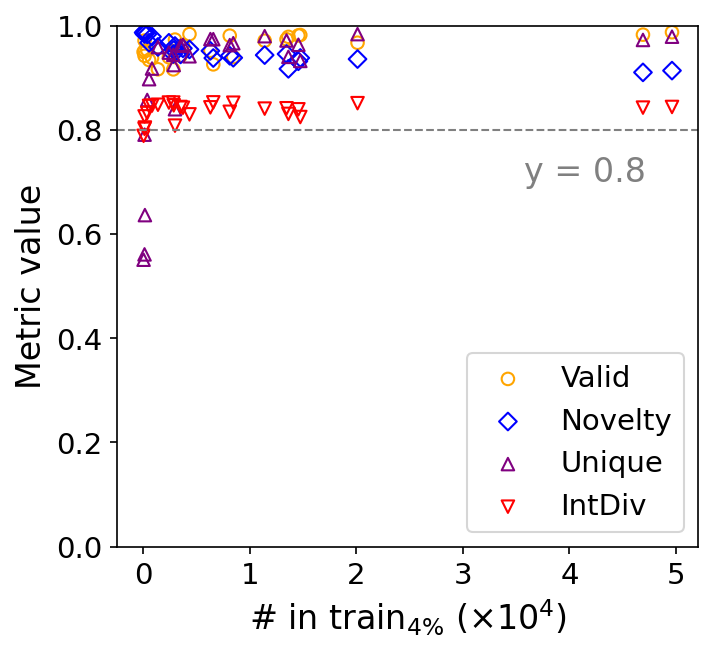

In [5]:
hac = metric['n_train'] / 10000
valid = metric['valid']
novel = metric['novel']
unique = metric['unique']
intdiv = metric['intDiv']


plt.figure(figsize=(5, 4.6), dpi=150)
plt.scatter(hac, valid, label='Valid', marker='o', facecolors='none', edgecolors='orange')
plt.scatter(hac, novel, label='Novelty', marker='D', facecolors='none', edgecolors='blue')
plt.scatter(hac, unique, label='Unique', marker='^', facecolors='none', edgecolors='Purple')
plt.scatter(hac, intdiv, label='IntDiv', marker='v', facecolors='none', edgecolors='red')

plt.xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=16)
plt.ylabel('Metric value', fontsize=16)
plt.legend(fontsize=14, loc='lower right')

# plt.axvline(x=0.1, color='gray', linestyle='dashed', linewidth=1)
plt.axhline(y=0.8, color='gray', linestyle='dashed', linewidth=1)

plt.text(0.7, 0.7, 'y = 0.8', transform=plt.gca().transAxes, fontsize=16, color='gray')
# plt.text(0.1, 0.05, 'x = 0.1', transform=plt.gca().transAxes, fontsize=16, color='gray')

plt.xticks(np.arange(0, 5+1, 1), fontsize=14)
plt.yticks(np.arange(0, 1.1, 0.2), fontsize=14)
plt.ylim((0, 1))

plt.show()

#### Scatter Plot of Property Errors
- logP, tPSA, QED
- property errors vs. # in train4%

In [6]:
# minimum of logP, tPSA, QED

print(f'MAE of logP: {metric["logP-MAE"].min():.3f}')
print(f'MAE of tPSA: {metric["tPSA-MAE"].min():.3f}')
print(f'MAE of  QED: {metric["QED-MAE"].min():.3f}')

MAE of logP: 0.180
MAE of tPSA: 3.076
MAE of  QED: 0.019


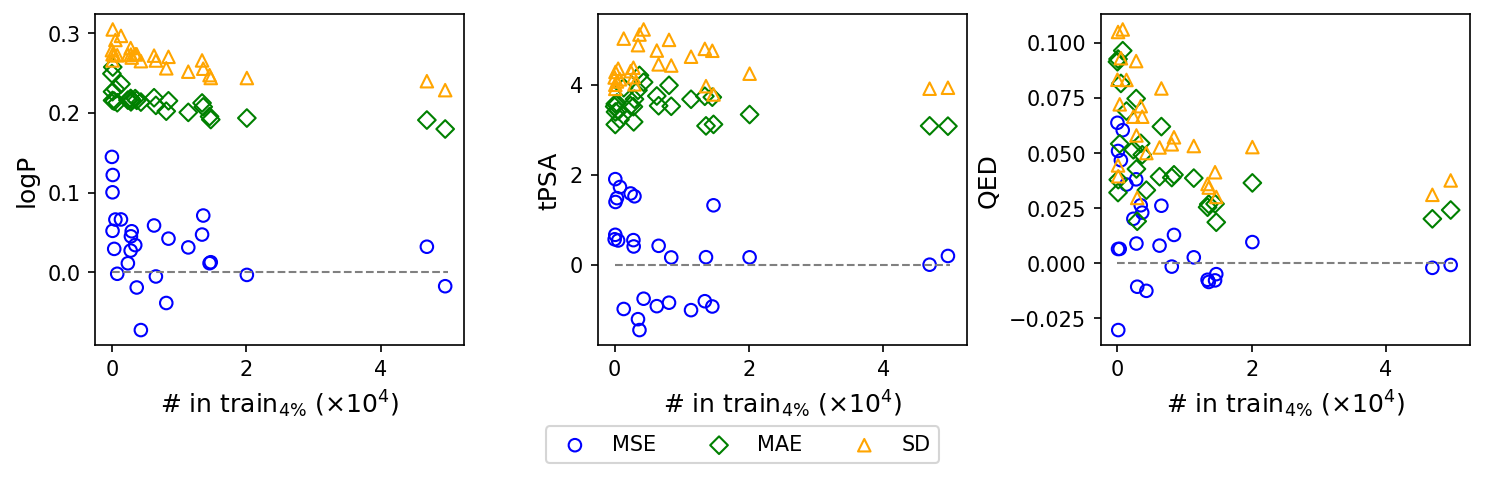

In [7]:
x = metric['n_train'] / 10000

# Plot 1: logP
y1_mse = metric['logP-MSE']
y1_mae = metric['logP-MAE']
y1_sd = metric['logP-SD']

# Plot 2: tPSA
y2_mse = metric['tPSA-MSE']
y2_mae = metric['tPSA-MAE']
y2_sd = metric['tPSA-SD']

# Plot 3: QED
y3_mse = metric['QED-MSE']
y3_mae = metric['QED-MAE']
y3_sd = metric['QED-SD']

fig, axes = plt.subplots(1, 3, figsize=(10, 3), dpi=150)

# Plot 1: logP
axes[0].scatter(x, y1_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[0].scatter(x, y1_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[0].scatter(x, y1_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[0].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[0].set_ylabel('logP', fontsize=12)
axes[0].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 2: tPSA
axes[1].scatter(x, y2_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[1].scatter(x, y2_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[1].scatter(x, y2_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[1].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[1].set_ylabel('tPSA', fontsize=12)
axes[1].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Plot 3: QED
axes[2].scatter(x, y3_mse, label='MSE', marker='o', facecolors='none', edgecolors='blue')
axes[2].scatter(x, y3_mae, label='MAE', marker='D', facecolors='none', edgecolors='green')
axes[2].scatter(x, y3_sd, label='SD', marker='^', facecolors='none', edgecolors='orange')
axes[2].set_xlabel(r'# in $\mathdefault{train}_{4\%}\ (\times 10^4)$', fontsize=12)
axes[2].set_ylabel('QED', fontsize=12)
axes[2].plot([0, 5], [0, 0], color='gray', linewidth=1, linestyle='dashed')

# Common legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.07))

plt.tight_layout()
plt.show()

#### Case Study: logP, tPSA, QED = 1, 30, 0.60

In [21]:
# target properties

target_logP = 1
target_tPSA = 30
target_QED = 0.6

prop_combination_no = 0


# filter functions

def property_filter(descriptor):
    filtered = descriptor[(target_logP - tol[0] <= descriptor.logP) & (descriptor.logP <= target_logP + tol[0])]
    filtered = filtered[(target_tPSA - tol[1] <= filtered.tPSA) & (filtered.tPSA <= target_tPSA + tol[1])]
    filtered = filtered[(target_QED - tol[2] <= filtered.QED) & (filtered.QED <= target_QED + tol[2])]
    return filtered


def specific_filter(descriptor):
    filtered = descriptor[(target_logP - tol[0] <= descriptor.logP) & (descriptor.logP <= target_logP + tol[0])]
    filtered = filtered[(target_tPSA - tol[1] <= filtered.tPSA) & (filtered.tPSA <= target_tPSA)]
    filtered = filtered[(target_QED - tol[2] <= filtered.QED) & (filtered.QED <= target_QED + tol[2])]
    return filtered

In [22]:
# get descriptors of the generated molecules

descriptor1 = pd.read_csv(os.path.join(file_folder, f'{file_name_list[0]}/prop{prop_combination_no}.csv'), index_col=[0])
descriptor2 = pd.read_csv(os.path.join(file_folder, f'{file_name_list[1]}/prop{prop_combination_no}.csv'), index_col=[0])
descriptor3 = pd.read_csv(os.path.join(file_folder, f'{file_name_list[2]}/prop{prop_combination_no}.csv'), index_col=[0])

descriptor1 = descriptor1.dropna(subset='smiles')
descriptor2 = descriptor2.dropna(subset='smiles')
descriptor3 = descriptor3.dropna(subset='smiles')

descriptor = pd.concat([descriptor1, descriptor2, descriptor3], axis=0)

descriptor.head()

,smiles,logP,tPSA,QED,SAS,NP,MW,HAC,HBA,HBD
0,C#CCN1CCN(CC(=O)N(CC(F)(F)F)C(C)C)CC1,1.0365,26.79,0.710161,2.616805,-2.212360,305.344,21,3,0
1,O=C(CN1CCN(CC(F)(F)C(F)F)CC1)N1CC=CC1,0.9028,26.79,0.557683,2.908871,-1.446183,309.307,21,3,0
2,C#CCN1CCN(C2CCN(C3CCCCC3)C2=O)CC1,1.1708,26.79,0.729878,3.015331,-0.889972,289.423,21,3,0
3,C#CCN1CCN(CC(=O)N2CCC(N(C(C)C)C(C)C)CC2)CC1,1.3470,30.03,0.677996,2.697337,-1.473579,348.535,25,4,0
4,O=C(C1CC1)N1CCN2CCN(C3CCN(CC(F)(F)F)CC3)CC21,1.2090,30.03,0.756915,3.222893,-1.387797,360.424,25,4,0


In [17]:
train = pd.read_csv('/fileserver-gamma/chaoting/ML/dataset/moses/raw/train.csv', index_col=[0])


subtr = train[(target_logP - tol[0] <= train.logP) & (train.logP <= target_logP + tol[0])]
subtr = subtr[(target_tPSA - tol[1] <= subtr.tPSA) & (subtr.tPSA <= target_tPSA + tol[1])]
subtr = subtr[(target_QED - tol[2] <= subtr.QED) & (subtr.QED <= target_QED + tol[2])]

print('# train near the property conditions:', len(subtr))


subtr = train[(target_logP - tol[0] <= train.logP) & (train.logP <= target_logP + tol[0])]
subtr = subtr[(target_tPSA - tol[1] <= subtr.tPSA) & (subtr.tPSA <= target_tPSA)]
subtr = subtr[(target_QED - tol[2] <= subtr.QED) & (subtr.QED <= target_QED + tol[2])]

print('# train near the property conditions (tPSA has different range):', len(subtr))

# train near the property conditions: 13
# train near the property conditions (tPSA has different range): 0


In [18]:
# filter properties

filtered1 = property_filter(descriptor1)
filtered2 = property_filter(descriptor2)
filtered3 = property_filter(descriptor3)
filtered = property_filter(descriptor)


print('# successful_valid (1):', len(filtered1))
print('# successful_valid (2):', len(filtered2))
print('# successful_valid (3):', len(filtered3))
print('--------------------------------')
print('# successful_unique (1):', len(filtered1.drop_duplicates(subset='smiles')))
print('# successful_unique (2):', len(filtered2.drop_duplicates(subset='smiles')))
print('# successful_unique (3):', len(filtered3.drop_duplicates(subset='smiles')))
print('--------------------------------')
print('# successful_unique in total:', len(filtered.drop_duplicates(subset='smiles')))

# successful_valid (1): 1006
# successful_valid (2): 999
# successful_valid (3): 1314
--------------------------------
# successful_unique (1): 825
# successful_unique (2): 787
# successful_unique (3): 1000
--------------------------------
# successful_unique in total: 2348


In [19]:
# filter specific properties

specific_filtered1 = specific_filter(descriptor1)
specific_filtered2 = specific_filter(descriptor2)
specific_filtered3 = specific_filter(descriptor3)
specific_filtered = specific_filter(descriptor)


print('# successful_valid (1):', len(specific_filtered1))
print('# successful_valid (2):', len(specific_filtered2))
print('# successful_valid (3):', len(specific_filtered3))
print('--------------------------------')
print('# successful_unique (1):', len(specific_filtered1.drop_duplicates(subset='smiles')))
print('# successful_unique (2):', len(specific_filtered2.drop_duplicates(subset='smiles')))
print('# successful_unique (3):', len(specific_filtered3.drop_duplicates(subset='smiles')))
print('--------------------------------')
print('# successful_unique in total:', len(specific_filtered.drop_duplicates(subset='smiles')))

# successful_valid (1): 285
# successful_valid (2): 179
# successful_valid (3): 470
--------------------------------
# successful_unique (1): 260
# successful_unique (2): 166
# successful_unique (3): 405
--------------------------------
# successful_unique in total: 771


In [26]:
specific_filtered['scaffold'] = mapper(murcko_scaffold, specific_filtered['smiles'], n_jobs=16)

unique_specific_filtered = specific_filtered.drop_duplicates(subset='smiles')

novel_unique_specific_filtered_molecules = unique_specific_filtered[~unique_specific_filtered['scaffold'].isin(train['scaffold'])]
novel_unique_specific_filtered_scaffolds = novel_unique_specific_filtered_molecules.drop_duplicates(subset=['scaffold'])

print('# novel and unique molecules:', len(novel_unique_specific_filtered_molecules))
print('# novel and unique scaffolds:', len(novel_unique_specific_filtered_scaffolds))

# novel and unique molecules: 315
# novel and unique scaffolds: 264


In [29]:
df = novel_unique_specific_filtered_scaffolds.copy()
df['logP-MAE'] = (df['logP'] - target_logP).abs()
df['tPSA-MAE'] = (df['tPSA'] - target_tPSA).abs()
df['QED-MAE'] = (df['QED'] - target_QED).abs()

In [30]:
import itertools

def get_combinations(lst):
    combinations = []
    for r in range(1, len(lst) + 1):
        permutations = itertools.permutations(lst, r)
        combinations.extend(permutations)
    return combinations

prop_mae = get_combinations(['logP-MAE', 'tPSA-MAE', 'QED-MAE'])

In [36]:
cumm_df = None

for i, mae in enumerate(prop_mae):
    sorted_df = df.sort_values(by=list(mae))
    if i == 0:
        cumm_df = sorted_df[:3].copy()
    else:
        cumm_df = pd.concat([cumm_df, sorted_df[:3]], axis=0)

cumm_df = cumm_df.drop_duplicates('smiles')
cumm_df = cumm_df.reset_index(drop=True)

In [35]:
n = 8
descriptions = []
for i in range(n):
    descriptions.append(f'logP={cumm_df.loc[i, "logP"]:.1f} '
                        f'tPSA={cumm_df.loc[i, "tPSA"]:.0f} '
                        f'QED={cumm_df.loc[i, "QED"]:.2f}')
smiles = cumm_df['smiles'][[0,1,2,3,5,6,7,8]]
scaffold = mapper(murcko_scaffold, smiles, n_jobs=1)

plot_smiles_group(
    smiles=smiles,
    substructure=scaffold,
    save_path='./1.png',
    img_size=(500, 350),
    n_per_mol=4,
    descriptions=descriptions
)

In [101]:
cumm_df.to_csv("/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/prop_sampling/case-study/evaluation.csv")

In [37]:
# from Utils.smiles import plot_smiles

# file_folder = '/fileserver-gamma/chaoting/ML/cvae-transformer/Inference-Dataset/moses/p-sampling/case-study/'

# for i in range(len(cumm_df)):
#     plot_smiles(cumm_df['SMILES'].iloc[i], os.path.join(file_folder, f'smiles-{i}.png'), size=(500,260))
#     plot_smiles(cumm_df['scaffold'].iloc[i], os.path.join(file_folder, f'scaffold-{i}.png'), size=(500,260))